In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PEPit import PEP
from PEPit.functions import SmoothStronglyConvexFunction
from PEPit.primitive_steps import inexact_gradient_step
import cvxpy as cp

In [2]:
def wc_gradient_descent(mu, L, gamma, n, verbose=1, metric = 0):
    """
    Args:
        mu (float): the strongly-convex constant
        L (float): the smoothness parameter.
        gamma (float or list): step-size (either constant or non-constant)
        n (int): number of iterations.
        verbose (int): Level of information details to print.
                        - -1: No verbose at all.
                        - 0: This example's output.
                        - 1: This example's output + PEPit information.
                        - 2: This example's output + PEPit information + CVXPY details.
        metric (int): Metric used to evaluate the convergence.
                        - 0: ||x_n - x_*||^2 <= c_0 ||x_0 - x_*||^2
                        - 1: f(x_n) - f_* <= c_1 ||x_0 - x_*||^2
                        - 2: nabla f(x_n)^2 <= c_2 (f(x_0) - f_*)
                        - 3: nabla f(x_n)^2 <= c_3 ||x_0 - x_*||^2 
    """
    
    # Instantiate PEP
    problem = PEP()

    # Declare a strongly convex smooth function
    func = problem.declare_function(SmoothStronglyConvexFunction, mu=mu, L=L)

    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    xs = func.stationary_point()
    fs = func(xs)

    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()

    # Run n steps of the GD method
    x = x0
    try: # If gamma is a constant (float) stepsize
        for i in range(n):
            x = x - gamma * func.gradient(x)
    except: # If gamma is a non-constant (list) stepsize
        for i in range(n):
            x = x - gamma[i] * func.gradient(x)
            
    # Set the initial constraint that is the distance between x0 and x^*
    if metric == 0 or metric == 1 or metric == 3:
        problem.set_initial_condition((x0 - xs) ** 2 <= 1) 
    elif metric == 2:
        problem.set_initial_condition((func(x0) - func(xs)) <= 1)
        
    # Set the performance metric to the function values accuracy
    if metric == 0:
        problem.set_performance_metric((x - xs) ** 2)
    elif metric == 1:
        problem.set_performance_metric(func(x) - fs)
    elif metric == 2 or metric == 3:
        problem.set_performance_metric(func.gradient(x) ** 2)

    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(wrapper = "cvxpy", solver = "MOSEK", tol_dimension_reduction = 1e-6, dimension_reduction_heuristic='trace', verbose=pepit_verbose)

    # Compute theoretical guarantee (for comparison)
    theoretical_tau = L / (2 * (2 * n * L * gamma + 1)) # To change

    # Print conclusion if required
    if verbose != -1:
        if metric == 0:
            print('\tPEPit guarantee:\t ||x_n - x_*||^2 <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))
        elif metric == 1:
            print('\tPEPit guarantee:\t f(x_n) - f_* <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))
        elif metric == 2:
            print('\tPEPit guarantee:\t nabla f(x_n)^2 <= {:.6} (f(x_0) - f_*)'.format(pepit_tau))
        elif metric == 3:
            print('\tPEPit guarantee:\t nabla f(x_n)^2 <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))

    # Return the worst-case guarantee of the evaluated method (and the reference theoretical value)
    return pepit_tau, theoretical_tau

def inexact_wc_gradient_descent(mu, L, gamma, n, verbose=1, metric = 0, epsilon = 0.):
    """
    Args:
        mu (float): the strongly-convex constant
        L (float): the smoothness parameter.
        gamma (float or list): step-size (either constant or non-constant)
        n (int): number of iterations.
        verbose (int): Level of information details to print.
                        - -1: No verbose at all.
                        - 0: This example's output.
                        - 1: This example's output + PEPit information.
                        - 2: This example's output + PEPit information + CVXPY details.
        metric (int): Metric used to evaluate the convergence.
                        - 0: ||x_n - x_*||^2 <= c_0 ||x_0 - x_*||^2
                        - 1: f(x_n) - f_* <= c_1 ||x_0 - x_*||^2
                        - 2: nabla f(x_n)^2 <= c_2 (f(x_0) - f_*)
                        - 3: nabla f(x_n)^2 <= c_3 ||x_0 - x_*||^2
        epsilon (float) : level of inaccuracy
    """
    
    # Instantiate PEP
    problem = PEP()

    # Declare a strongly convex smooth function
    func = problem.declare_function(SmoothStronglyConvexFunction, mu=mu, L=L)

    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    xs = func.stationary_point()
    fs = func(xs)

    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()

    # Run n steps of the GD method
    x = x0
    try: # If gamma is a constant (float) stepsize
        for i in range(n):
            x, dx, fx = inexact_gradient_step(x, func, gamma=gamma, epsilon=epsilon, notion='relative')
    except: # If gamma is a non-constant (list) stepsize
        for i in range(n):
            x, dx, fx = inexact_gradient_step(x, func, gamma=gamma[i], epsilon=epsilon, notion='relative')
            
    # Set the initial constraint that is the distance between x0 and x^*
    if metric == 0 or metric == 1 or metric == 3:
        problem.set_initial_condition((x0 - xs) ** 2 <= 1)
    elif metric == 2:
        problem.set_initial_condition((func(x0) - func(xs)) <= 1)

    # Set the performance metric to the function values accuracy
    if metric == 0:
        problem.set_performance_metric((x - xs) ** 2)
    elif metric == 1:
        problem.set_performance_metric(func(x) - fs)
    elif metric == 2 or metric == 3:
        problem.set_performance_metric(func.gradient(x) ** 2)

    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose=pepit_verbose, solver = cp.MOSEK, dimension_reduction_heuristic="trace", tol_dimension_reduction=1e-5)

    # Compute theoretical guarantee (for comparison) only true if delta=0
    theoretical_tau = L / (2 * (2 * n * L * gamma + 1))

    # Print conclusion if required
    if verbose != -1:
        if metric == 0:
            print('\tPEPit guarantee:\t ||x_n - x_*||^2 <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))
        elif metric == 1:
            print('\tPEPit guarantee:\t f(x_n) - f_* <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))
        elif metric == 2:
            print('\tPEPit guarantee:\t nabla f(x_n)^2 <= {:.6} (f(x_n) - f_*)'.format(pepit_tau))
        elif metric == 3:
            print('\tPEPit guarantee:\t nabla f(x_n)^2 <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))

    # Return the worst-case guarantee of the evaluated method (and the reference theoretical value)
    return pepit_tau, theoretical_tau

def wc_accelerated_gradient_convex(mu, L, n, gamma, verbose=1, metric = 2):
    """
    Args:
        mu (float): the strongly-convex constant
        L (float): the smoothness parameter.
        gamma (float or list): step-size (either constant or non-constant)
        n (int): number of iterations.
        verbose (int): Level of information details to print.
                        - -1: No verbose at all.
                        - 0: This example's output.
                        - 1: This example's output + PEPit information.
                        - 2: This example's output + PEPit information + CVXPY details.
        metric (int): Metric used to evaluate the convergence.
                        - 0: ||x_n - x_*||^2 <= c_0 ||x_0 - x_*||^2
                        - 1: f(x_n) - f_* <= c_1 ||x_0 - x_*||^2
                        - 2: nabla f(x_n)^2 <= c_2 (f(x_0) - f_*)
                        - 3: nabla f(x_n)^2 <= c_3 ||x_0 - x_*||^2 
        epsilon (float) : level of inaccuracy
    """
    # Instantiate PEP
    problem = PEP()

    # Declare a strongly convex smooth function
    func = problem.declare_function(SmoothStronglyConvexFunction, mu=mu, L=L)

    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    xs = func.stationary_point()
    fs = func(xs)

    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()

    # Set the initial constraint that is the distance between x0 and x^*
    if metric == 0 or metric == 1 or metric == 3:
        problem.set_initial_condition((x0 - xs) ** 2 <= 1)
    elif metric == 2:
        problem.set_initial_condition((func(x0) - fs) <= 1)

    # Run n steps of the fast gradient method
    x_new = x0
    y = x0

    x_list = [x0]

    try:
        for i in range(n):
            x_old = x_new
            x_new = y - gamma * func.gradient(y)
            y = x_new + i / (i + 3) * (x_new - x_old)
            x_list.append(x_new)
    except:
        for i in range(n):
            x_old = x_new
            x_new = y - gamma[i] * func.gradient(y)
            y = x_new + i / (i + 3) * (x_new - x_old)
            x_list.append(x_new)

    # Set the performance metric to the function values accuracy
    if metric == 0:
        problem.set_performance_metric((x_new - xs) ** 2)
    elif metric == 1:
        problem.set_performance_metric(func(x_new) - fs)
    elif metric == 2 or metric == 3:
        for i in range(len(x_list)):
            problem.set_performance_metric(func.gradient(x_list[i]) ** 2)

    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose=pepit_verbose, dimension_reduction_heuristic='trace',tol_dimension_reduction=1e-6)

    # Theoretical guarantee (for comparison) only tight for mu=0 and delta=0
    theoretical_tau = 2 * L / (n ** 2 + 5 * n + 6)
    if mu != 0:
        print('Warning: momentum is tuned for non-strongly convex functions.')

    # Print conclusion if required
    if verbose != -1:
        print('*** Example file: worst-case performance of accelerated gradient method ***')
        print('\tPEPit guarantee:\t f(x_n)-f_* <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))
        print('\tTheoretical guarantee:\t f(x_n)-f_* <= {:.6} ||x_0 - x_*||^2'.format(theoretical_tau))

    # Return the worst-case guarantee of the evaluated method (and the reference theoretical value)
    return pepit_tau, theoretical_tau

def inexact_wc_accelerated_gradient_descent(mu, L, gamma, n, verbose=1, metric = 0, epsilon = 0.):
    """
    Args:
        mu (float): the strongly-convex constant
        L (float): the smoothness parameter.
        gamma (float or list): step-size (either constant or non-constant)
        n (int): number of iterations.
        verbose (int): Level of information details to print.
                        - -1: No verbose at all.
                        - 0: This example's output.
                        - 1: This example's output + PEPit information.
                        - 2: This example's output + PEPit information + CVXPY details.
        metric (int): Metric used to evaluate the convergence.
                        - 0: ||x_n - x_*||^2 <= c_0 ||x_0 - x_*||^2
                        - 1: f(x_n) - f_* <= c_1 ||x_0 - x_*||^2
                        - 2: nabla f(x_n)^2 <= c_2 (f(x_0) - f_*)
                        - 3: nabla f(x_n)^2 <= c_3 ||x_0 - x_*||^2 
        epsilon (float) : level of inaccuracy
    """
    # Instantiate PEP
    problem = PEP()

    # Declare a strongly convex smooth function
    func = problem.declare_function(SmoothStronglyConvexFunction, mu=mu, L=L)

    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    xs = func.stationary_point()
    fs = func(xs)

    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()

    # Set the initial constraint that is the distance between x0 and x^*
    if metric == 0 or metric == 1 or metric == 3:
        problem.set_initial_condition((x0 - xs) ** 2 <= 1)
    elif metric == 2:
        problem.set_initial_condition((func(x0) - fs) <= 1)

    # Run n steps of the IFGD method
    x_new = x0
    y = x0
    x_list = [x0]
    for i in range(n):
        x_old = x_new
        x_new, dy, fy = inexact_gradient_step(y, func, gamma=gamma, epsilon=epsilon, notion='relative')
        y = x_new + i / (i + 3) * (x_new - x_old)
        x_list.append(x_new)
    _, fx = func.oracle(x_new)

    # Set the performance metric to the function values accuracy
    if metric == 0:
        problem.set_performance_metric((x_new - xs) ** 2)
    elif metric == 1:
        problem.set_performance_metric(func(x_new) - fs)
    elif metric == 2 or metric == 3:
        for i in range(len(x_list)):
            problem.set_performance_metric(func.gradient(x_list[i]) ** 2)

    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose=pepit_verbose, solver = cp.MOSEK, dimension_reduction_heuristic = 'trace', tol_dimension_reduction=1e-5)

    # Compute theoretical guarantee (for comparison) only tight for mu=0 and delta=0
    theoretical_tau = L / (2 * (2 * n * L * gamma + 1))

    # Print conclusion if required
    if verbose != -1:
        if metric == 0:
            print('\tPEPit guarantee:\t ||x_n - x_*||^2 <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))
        elif metric == 1:
            print('\tPEPit guarantee:\t f(x_n) - f_* <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))
        elif metric == 2:
            print('\tPEPit guarantee:\t nabla f(x_n)^2 <= {:.6} (f(x_n) - f_*)'.format(pepit_tau))
        elif metric == 3:
            print('\tPEPit guarantee:\t nabla f(x_n)^2 <= {:.6} ||x_0 - x_*||^2'.format(pepit_tau))

    # Return the worst-case guarantee of the evaluated method (and the reference theoretical value)
    return pepit_tau, theoretical_tau

In [3]:
rho = 1 + np.sqrt(2)

def v_2(t):
    if t == 0:
        return float('inf')  # ν(0) is defined as positive infinity
    elif t < 0:
        raise ValueError("2-adic valuation is only defined for non-negative integers.")
    
    v = 0
    while t % 2 == 0:
        t //= 2
        v += 1
    
    return v

def h(n):
    to_ret = np.zeros((n))

    for i in range(n):
        to_ret[i] = 1 + rho ** (v_2(i+1) - 1)

    return to_ret

def generate_dynamic_steps(n):
    t = np.zeros(n)
    t[0] = np.sqrt(2)
    Tn_minus_1 = t[0]
    for i in range(1, n):
        term = Tn_minus_1
        t[i] = (-term + np.sqrt(term**2 + 8 * (term + 1))) / 2
        Tn_minus_1 += t[i]

    return t

In [4]:
def plot_scatter(x, y, color = 'blue', label = '', prefixe = plt, marker = None):
    if marker == None:
        prefixe.plot(x, y, color, label = label)
    else:
        prefixe.plot(x, y, color, label = label, marker = marker, markersize = 8)

In [5]:
delta_list = np.arange(0., 1.0, 0.1)

tau_cst= np.zeros(len(delta_list))
tau_dynamic = np.zeros(len(delta_list))
tau_silver = np.zeros(len(delta_list))
tau_FGM = np.zeros(len(delta_list))

list_max_FGM = np.array([50,8,8,7,5,4,3,3,2,2])
list_max_silver = np.array([47,3,3,1,1,0,0,0,0,0])
list_max_dynamic = np.array([50,5,2,1,1,0,0,0,0,0])

In [6]:
for i, delta in enumerate(delta_list):
    if delta == 0:
        tau_cst[i] = wc_gradient_descent(mu = 0, L = 1, gamma=1, n=50, verbose=-1, metric = 2)[0]
        tau_dynamic[i] = wc_gradient_descent(mu = 0, L = 1, gamma=generate_dynamic_steps(list_max_dynamic[i]), n=list_max_dynamic[i], verbose=-1, metric = 2)[0]
        tau_silver[i] = wc_gradient_descent(mu = 0, L = 1, gamma=h(list_max_silver[i]), n=list_max_silver[i], verbose=-1, metric = 2)[0]
        tau_FGM[i] = wc_accelerated_gradient_convex(mu = 0, L = 1, gamma=1, n=list_max_FGM[i], verbose=-1, metric = 2)[0]
        print(str((i+1)/len(delta_list) * 100) + "%",  end='\r')
    else:
        tau_cst[i] = inexact_wc_gradient_descent(mu = 0, L = 1, gamma=1, n=50, verbose=-1, metric = 2, epsilon=delta)[0]
        
        tau_FGM[i] = inexact_wc_accelerated_gradient_descent(mu = 0, L = 1, gamma=1, n=list_max_FGM[i], verbose=-1, metric = 2, epsilon=delta)[0]

        if list_max_dynamic[i] != 0:
            tau_dynamic[i] = inexact_wc_gradient_descent(mu = 0, L = 1, gamma=generate_dynamic_steps(list_max_dynamic[i]), n=list_max_dynamic[i], verbose=-1, metric = 2, epsilon=delta)[0]
            tau_silver[i] = inexact_wc_gradient_descent(mu = 0, L = 1, gamma=h(list_max_silver[i]), n=list_max_silver[i], verbose=-1, metric = 2, epsilon=delta)[0]
        else:
            tau_dynamic[i] = 2
            tau_silver[i] = 2
        print(str(100*(i+1)/len(delta_list)) + '%',  end='\r')

In [7]:
tau_cst_15 = np.zeros(len(delta_list))
tau_cst_15_divided = np.zeros(len(delta_list))

In [8]:
for i, delta in enumerate(delta_list):
    try:
        tau_cst_15[i] = inexact_wc_gradient_descent(mu = 0, L = 1, gamma=1.5, n=50, verbose=-1, metric = 2, epsilon=delta)[0]
    except:
        tau_cst_15[i] = 0
    try:
        tau_cst_15_divided[i] = inexact_wc_gradient_descent(mu = 0, L = 1, gamma=1.5/(1+delta), n=50, verbose=-1, metric = 2, epsilon=delta)[0]
    except:
        tau_cst_15_divided[i] = 0
    print(str((i+1)/len(delta_list) * 100) + "%",  end='\r')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


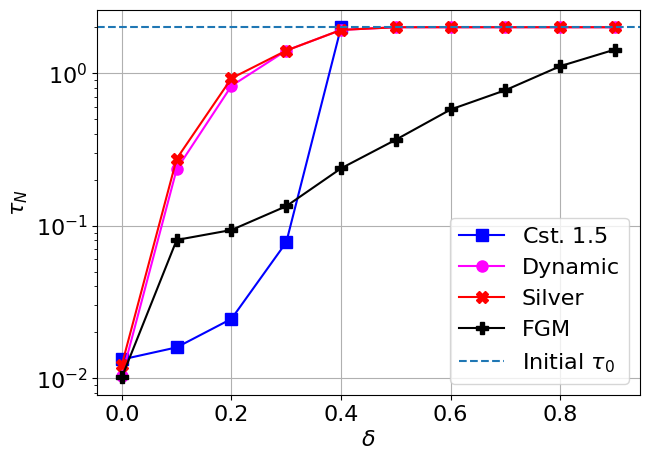

In [9]:
plt.figure(figsize = (7,5))
# plot_scatter(delta_list, tau_cst, label = r'Constant $1/L$', color = 'blue')
plot_scatter(delta_list[:5], np.concatenate((tau_cst_15[:4],[2])), label = r'Cst. $1.5$', color = 'blue', marker="s")
plot_scatter(delta_list, tau_dynamic, label = r'Dynamic', color = 'magenta', marker="o")
plot_scatter(delta_list, tau_silver, label = r'Silver', color = 'red',marker="X")
plot_scatter(delta_list, tau_FGM, label = r'FGM', color = 'black',marker="P")
plt.axhline(2, label = r'Initial $\tau_0$', linestyle = '--')
plt.yscale('log')
plt.xlabel(r'$\delta$', fontsize = 16)
plt.ylabel(r'$\tau_N$', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize = 16)
plt.grid()
plt.savefig("Images/PEP_diff_algo_diff_delta.eps", bbox_inches = 'tight')

In [10]:
tau_cst_divided = np.zeros(len(delta_list))
tau_dynamic_divided = np.zeros(len(delta_list))
tau_silver_divided = np.zeros(len(delta_list))
tau_FGM_divided = np.zeros(len(delta_list))

list_max_FGM_divided = np.array([50,9,9,9,9,8,8,7,6,6])
list_max_silver_divided = np.array([47,31,15,7,7,3,3,3,3,3])
list_max_dynamic_divided = np.array([50,50,50,50,50,50,50,50,50,50])

In [11]:
for i, delta in enumerate(delta_list):
    if delta == 0:
        tau_cst_divided[i] = wc_gradient_descent(mu = 0, L = 1, gamma=1, n=50, verbose=-1, metric = 2)[0]
        tau_dynamic_divided[i] = wc_gradient_descent(mu = 0, L = 1, gamma=generate_dynamic_steps(list_max_dynamic_divided[i]), n=list_max_dynamic_divided[i], verbose=-1, metric = 2)[0]
        tau_silver_divided[i] = wc_gradient_descent(mu = 0, L = 1, gamma=h(list_max_silver_divided[i]), n=list_max_silver_divided[i], verbose=-1, metric = 2)[0]
        tau_FGM_divided[i] = wc_accelerated_gradient_convex(mu = 0, L = 1, gamma=1, n=list_max_FGM_divided[i], verbose=-1, metric = 2)[0]
        print(str((i+1)/len(delta_list) * 100) + "%",  end='\r')
    else:
        tau_cst_divided[i] = inexact_wc_gradient_descent(mu = 0, L = 1, gamma=1/(1+delta), n=50, verbose=-1, metric = 2, epsilon=delta)[0]
        tau_FGM_divided[i] = inexact_wc_accelerated_gradient_descent(mu = 0, L = 1, gamma=1/(1+delta), n=list_max_FGM_divided[i], verbose=-1, metric = 2, epsilon=delta)[0]
        tau_dynamic_divided[i] = inexact_wc_gradient_descent(mu = 0, L = 1, gamma=generate_dynamic_steps(list_max_dynamic_divided[i])/(1+delta), n=list_max_dynamic_divided[i], verbose=-1, metric = 2, epsilon=delta)[0]
        tau_silver_divided[i] = inexact_wc_gradient_descent(mu = 0, L = 1, gamma=h(list_max_silver_divided[i])/(1+delta), n=list_max_silver_divided[i], verbose=-1, metric = 2, epsilon=delta)[0]
        print(str((i+1)/len(delta_list) * 100) + "%",  end='\r')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


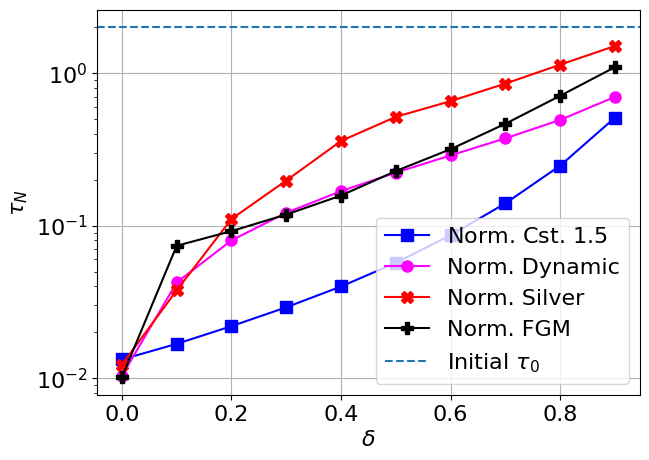

In [12]:
plt.figure(figsize=(7,5))
# plot_scatter(delta_list, tau_cst_divided, label = r'Constant $1/L$', color = 'blue')
plot_scatter(delta_list, tau_cst_15_divided, label = r'Norm. Cst. $1.5$', color = 'blue', marker="s")
plot_scatter(delta_list, tau_dynamic_divided, label = r'Norm. Dynamic', color = 'magenta',marker="o")
plot_scatter(delta_list, tau_silver_divided, label = r'Norm. Silver', color = 'red',marker="X")
plot_scatter(delta_list, tau_FGM_divided, label = r'Norm. FGM', color = 'black',marker="P")
plt.axhline(2, label = r'Initial $\tau_0$', linestyle = '--')
plt.yscale('log')
plt.xlabel(r'$\delta$', fontsize = 16)
plt.ylabel(r'$\tau_N$', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize = 16)
plt.grid()
plt.savefig("Images/PEP_diff_algo_divided_diff_delta.eps", bbox_inches = 'tight')